In [196]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
import random

In [197]:
# Import train data
ne_train = pd.read_csv("../../data/ne_train.csv")
s_train = pd.read_csv("../../data/s_train.csv")

# Import test data
ne_test = pd.read_csv("../../data/ne_test.csv")
s_test = pd.read_csv("../../data/s_test.csv")

In [198]:
ne_train_plot = pd.merge(ne_train.date, ne_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
ne_test_plot = pd.merge(ne_test.date, ne_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

s_train_plot = pd.merge(s_train.date, s_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
s_test_plot = pd.merge(s_test.date, s_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

In [199]:
ne_train_plot.set_index("date", inplace = True)
ne_test_plot.set_index("date", inplace = True)

s_train_plot.set_index("date", inplace = True)
s_test_plot.set_index("date", inplace = True)

In [200]:
ne_train.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)
ne_test.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)

s_train.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)
s_test.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)

In [83]:
# Log transform 
ne_train.y = np.log(ne_train.y)
ne_train_plot.covid_19_confirmed_cases = np.log(ne_train_plot.covid_19_confirmed_cases)
s_train.y = np.log(s_train.y)
s_train_plot.covid_19_confirmed_cases = np.log(s_train_plot.covid_19_confirmed_cases)

# Prophet Multiple Regressors
- From Multivariate EDA
    - NE: cat__social_distancing_encounters_grade_A, cat__social_distancing_encounters_grade_F, cat__social_distancing_travel_distance_grade_F, cat__social_distancing_total_grade_F, num__daily_state_test, num__precipitation, num__temperature have some weak correlation with covid_19_confirmed_cases
    - S: num__daily_state_test, num__temperature
- prior_scale default at 10
    - Decreasing the prior scale will add additional regularization
        - Dampens the effect of the regressor

In [18]:
help(Prophet.add_regressor)

Help on function add_regressor in module prophet.forecaster:

add_regressor(self, name, prior_scale=None, standardize='auto', mode=None)
    Add an additional regressor to be used for fitting and predicting.
    
    The dataframe passed to `fit` and `predict` will have a column with the
    specified name to be used as a regressor. When standardize='auto', the
    regressor will be standardized unless it is binary. The regression
    coefficient is given a prior with the specified scale parameter.
    Decreasing the prior scale will add additional regularization. If no
    prior scale is provided, self.holidays_prior_scale will be used.
    Mode can be specified as either 'additive' or 'multiplicative'. If not
    specified, self.seasonality_mode will be used. 'additive' means the
    effect of the regressor will be added to the trend, 'multiplicative'
    means it will multiply the trend.
    
    Parameters
    ----------
    name: string name of the regressor.
    prior_scale: opti

## Normal Prophet
- NE: MAE on test data = 3748 confirmed cases
    - Slightly higher MAE on test than the baseline Prophet (Univariate) model
- S: MAE on test data = 9293 confirmed cases
    - MAE is better than the tuned Prophet (Multivariate) model
    
    
## Normal Prophet - Tuned (Different regressors)
- NE: MAE on test data = 1642 confirmed cases
- S: MAE on test data = 9293 confirmed cases

### NE Region

In [255]:
ne_cols = ["cat__social_distancing_travel_distance_grade_F",
           "num__daily_state_test",
          "num__temperature",
          "num__precipitation",
          "cat__social_distancing_encounters_grade_A",
           "cat__social_distancing_encounters_grade_F",
          "cat__social_distancing_total_grade_F"]

In [256]:
ne_normal_prophet = Prophet()

In [257]:
ne_normal_prophet.add_regressor("cat__social_distancing_travel_distance_grade_F")
ne_normal_prophet.add_regressor("num__daily_state_test")
ne_normal_prophet.add_regressor("num__temperature")
ne_normal_prophet.add_regressor("num__precipitation")
ne_normal_prophet.add_regressor("cat__social_distancing_encounters_grade_F")
ne_normal_prophet.add_regressor("cat__social_distancing_encounters_grade_A")
ne_normal_prophet.add_regressor("cat__social_distancing_total_grade_F")

In [258]:
ne_normal_prophet.fit(ne_train)

22:36:32 - cmdstanpy - INFO - Chain [1] start processing
22:36:32 - cmdstanpy - INFO - Chain [1] done processing


In [259]:
ne_normal_future = ne_normal_prophet.make_future_dataframe(periods=ne_train.shape[0])
ne_normal_future = pd.merge(ne_normal_future, ne_train.loc[:, ne_cols], left_index = True, right_index = True)
ne_normal_forecast = ne_normal_prophet.predict(ne_normal_future)

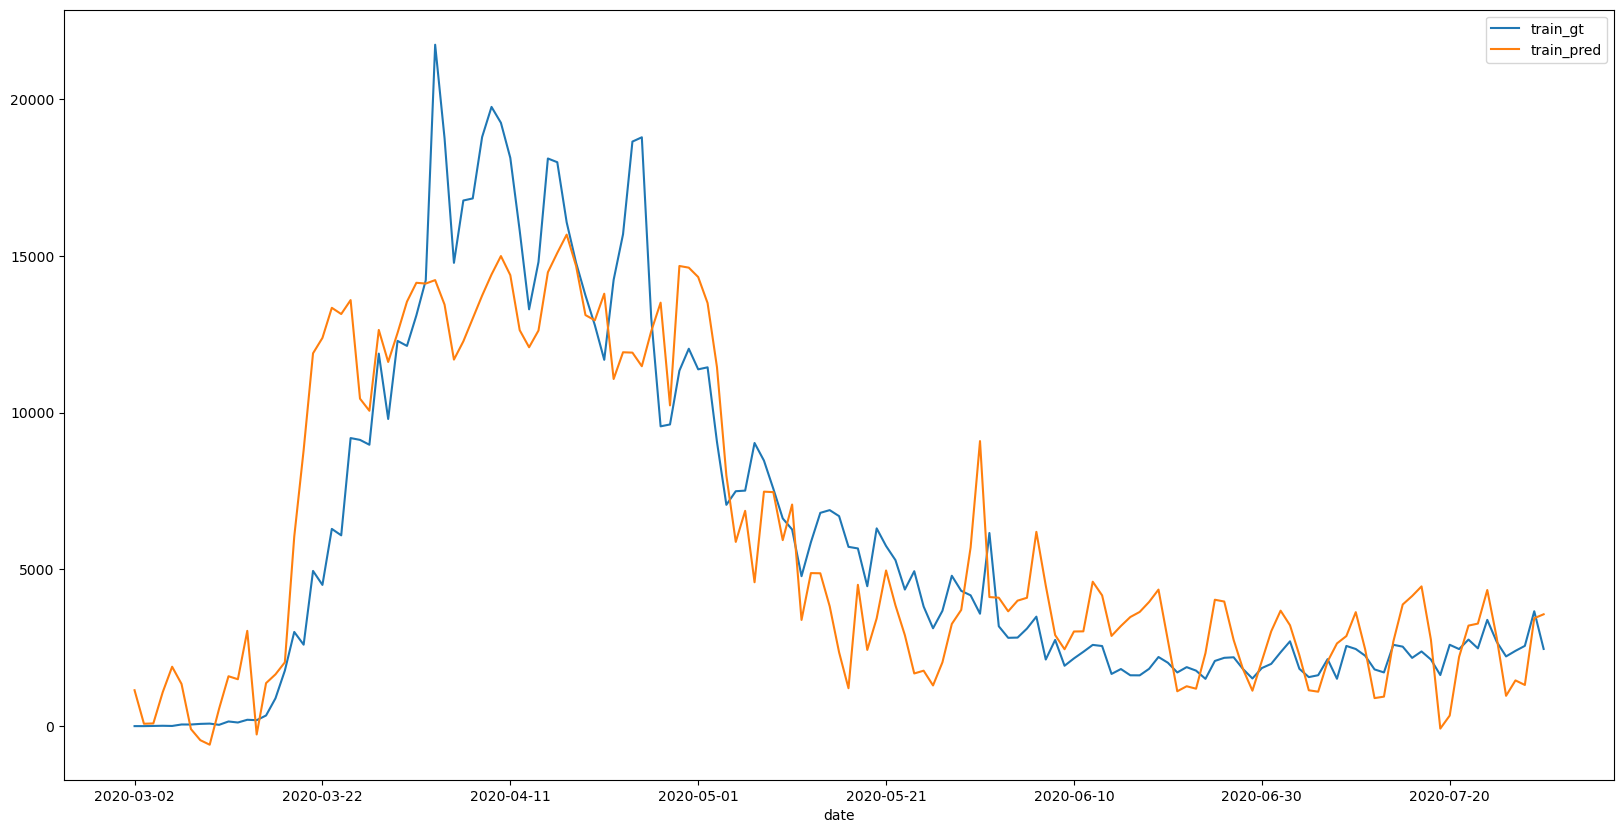

In [260]:
# Visualizing train data fitted values
ne_train_pred = ne_normal_forecast["yhat"]
ne_train_pred.index = ne_train_plot.index
pd.concat([ne_train_plot, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [261]:
ne_normal_future = ne_normal_prophet.make_future_dataframe(periods=ne_test.shape[0])
ne_normal_future = pd.merge(ne_normal_future, ne_test.loc[:, ne_cols], left_index = True, right_index = True)
ne_normal_forecast = ne_normal_prophet.predict(ne_normal_future)

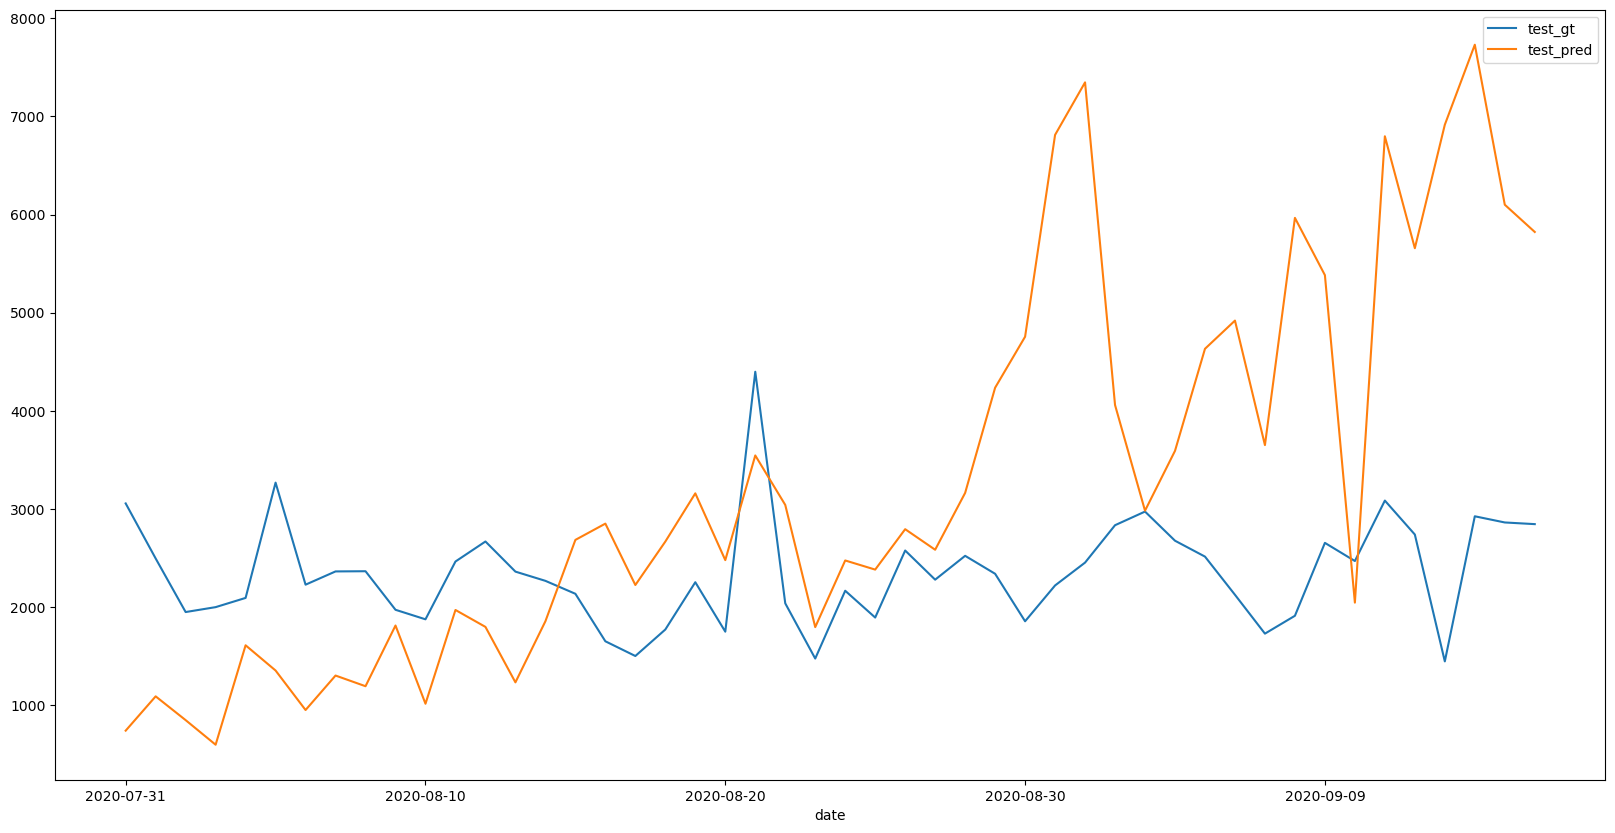

In [262]:
# Visualizing test data fitted values
ne_test_pred = ne_normal_forecast["yhat"]
ne_test_pred.index = ne_test_plot.index
pd.concat([ne_test_plot, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [263]:
# MAE on test data
mean_absolute_error(ne_test_plot, ne_test_pred)

1641.5725916337535

### S Region

In [44]:
s_cols = ["num__daily_state_test"]

In [45]:
s_normal_prophet = Prophet()

In [46]:
s_normal_prophet.add_regressor("num__daily_state_test")

In [47]:
s_normal_prophet.fit(s_train)

19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
s_normal_future = s_normal_prophet.make_future_dataframe(periods=s_train.shape[0])
s_normal_future = pd.merge(s_normal_future, s_train.loc[:, ne_cols], left_index = True, right_index = True)
s_normal_forecast = s_normal_prophet.predict(s_normal_future)

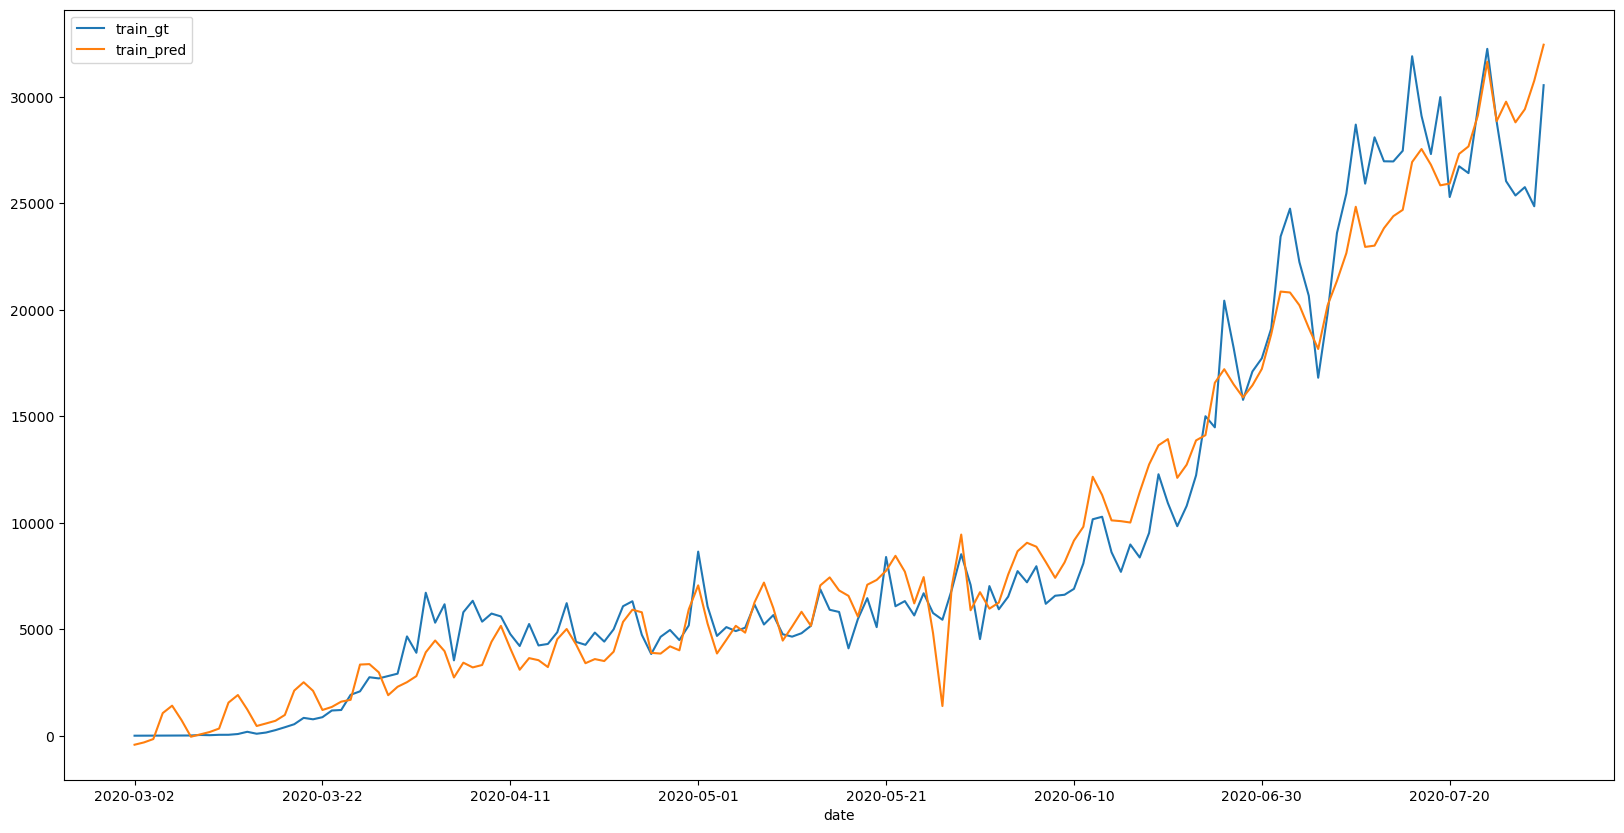

In [49]:
# Visualizing train data fitted values
s_train_pred = s_normal_forecast["yhat"]
s_train_pred.index = s_train_plot.index
pd.concat([s_train_plot, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [50]:
s_normal_future = s_normal_prophet.make_future_dataframe(periods=s_test.shape[0])
s_normal_future = pd.merge(s_normal_future, s_test.loc[:, s_cols], left_index = True, right_index = True)
s_normal_forecast = s_normal_prophet.predict(s_normal_future)

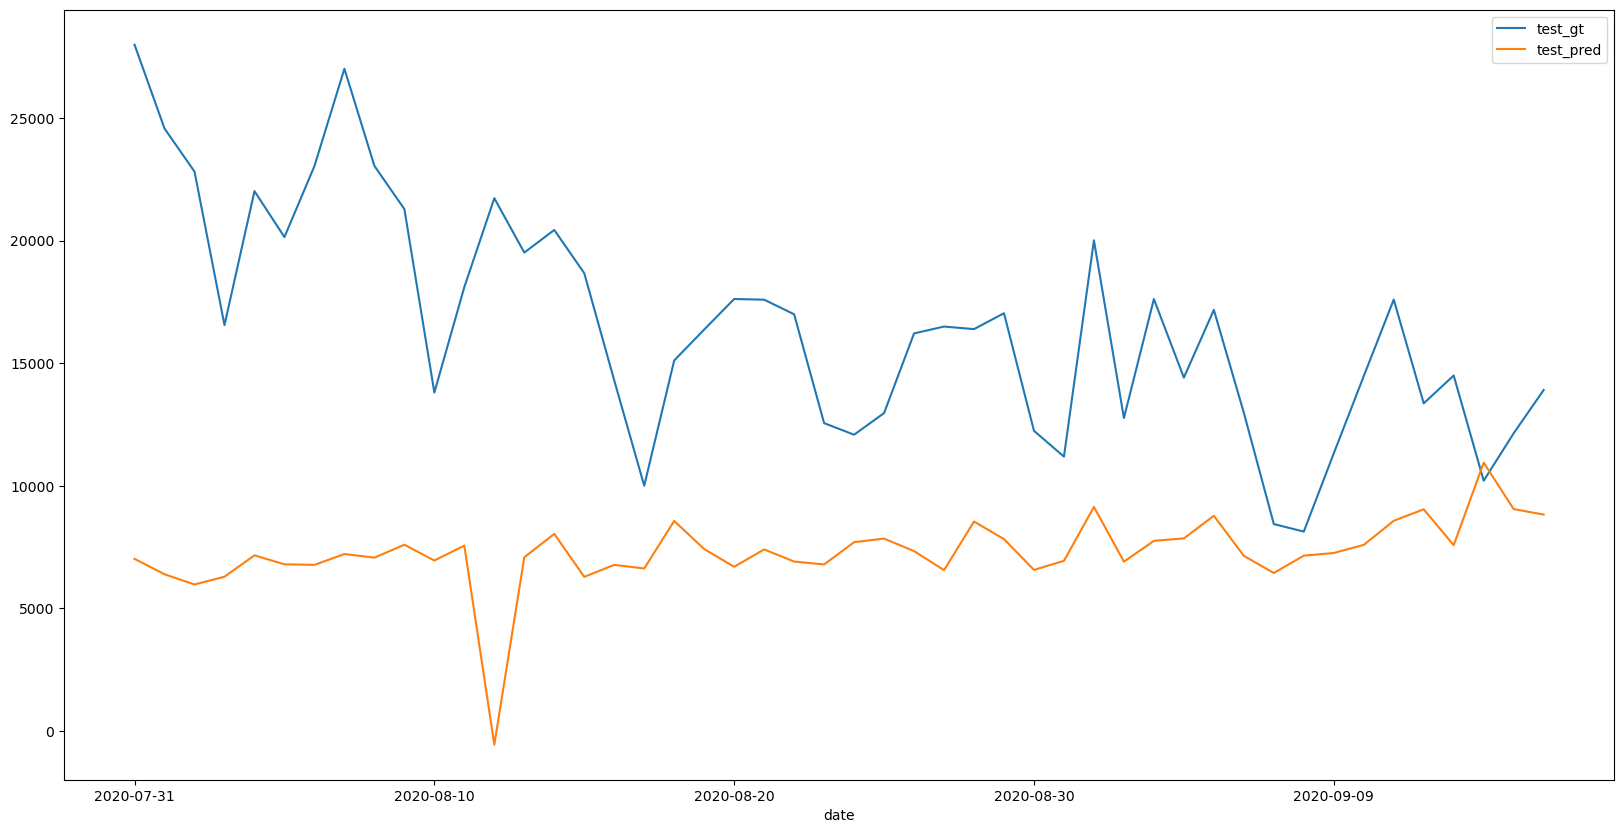

In [51]:
# Visualizing test data fitted values
s_test_pred = s_normal_forecast["yhat"]
s_test_pred.index = s_test_plot.index
pd.concat([s_test_plot, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [53]:
# MAE on test data
mean_absolute_error(s_test_plot, s_test_pred)

9292.90447662061

# Tuned Prophet
- NE: MAE on test data = 16467 confirmed cases
- S: MAE on test data = 13752 confirmed cases

## NE Region

In [175]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95]
}

In [176]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
ne_maes = []

In [177]:
# Randomly choose 50 combinations
to_tune = random.sample(all_params, 50)

In [178]:
# Use cross validation to evaluate all parameters
for params in to_tune:
    ne_tuned_prophet = Prophet(**params)
    ne_tuned_prophet.add_country_holidays(country_name='US')
    ne_tuned_prophet.add_regressor("cat__social_distancing_travel_distance_grade_F")
    ne_tuned_prophet.add_regressor("num__daily_state_test")
    
    ne_tuned_prophet.fit(ne_train) 
    
    df_cv = cross_validation(ne_tuned_prophet, initial='90 days', 
                             period='15 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    ne_maes.append(df_p["mae"].values[0])

20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:14 - cmdstanpy - INFO - Chain [1] done processing
20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:14 - cmdstanpy - INFO - Chain [1] done processing
20:15:14 - cmdstanpy - INFO - Chain [1] done processing
20:15:15 - cmdstanpy - INFO - Chain [1] done processing
20:15:15 - cmdstanpy - INFO - Chain [1] start processing
20:15:15 - cmdstanpy - INFO - Chain [1] done processing
20:15:15 - cmdstanpy - INFO - Chain [1] start processing
20:15:15 - cmdstanpy - INFO - Chain [1] start processing
20:15:15 - cmdstanpy - INFO - Chain [1] start processing
20:15:15 - cmdstanpy - INFO - Chain [1] done processing
20:15:15 - cmdstanpy - INFO - Chain [1] done processing
20:15:16 - cmdstanpy - INFO - Chain [1] done processing
20:15:16 - cmdstanpy - INFO - Chain [1] start processing
20:15:16 - cmdstanpy - INFO - Chain [1]

20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:25 - cmdstanpy - INFO - Chain [1] done processing
20:15:25 - cmdstanpy - INFO - Chain [1] start processing
20:15:25 - cmdstanpy - INFO - Chain [1] done processing
20:15:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:15:25 - cmdstanpy - INFO - Chain [1] start processing
20:15:25 - cmdstanpy - INFO - Chain [1] done processing
20:15:25 - cmdstanpy - INFO - Chain [1] start processing
20:15:26 - cmdstanpy - INFO - Chain [1] start process

20:15:35 - cmdstanpy - INFO - Chain [1] start processing
20:15:35 - cmdstanpy - INFO - Chain [1] done processing
20:15:35 - cmdstanpy - INFO - Chain [1] start processing
20:15:35 - cmdstanpy - INFO - Chain [1] start processing
20:15:35 - cmdstanpy - INFO - Chain [1] start processing
20:15:35 - cmdstanpy - INFO - Chain [1] done processing
20:15:35 - cmdstanpy - INFO - Chain [1] done processing
20:15:35 - cmdstanpy - INFO - Chain [1] done processing
20:15:36 - cmdstanpy - INFO - Chain [1] start processing
20:15:36 - cmdstanpy - INFO - Chain [1] done processing
20:15:36 - cmdstanpy - INFO - Chain [1] start processing
20:15:36 - cmdstanpy - INFO - Chain [1] start processing
20:15:36 - cmdstanpy - INFO - Chain [1] start processing
20:15:36 - cmdstanpy - INFO - Chain [1] done processing
20:15:36 - cmdstanpy - INFO - Chain [1] done processing
20:15:36 - cmdstanpy - INFO - Chain [1] done processing
20:15:37 - cmdstanpy - INFO - Chain [1] start processing
20:15:37 - cmdstanpy - INFO - Chain [1]

20:15:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:15:47 - cmdstanpy - INFO - Chain [1] start processing
20:15:47 - cmdstanpy - INFO - Chain [1] done processing
20:15:48 - cmdstanpy - INFO - Chain [1] start processing
20:15:48 - cmdstanpy - INFO - Chain [1] start processing
20:15:48 - cmdstanpy - INFO - Chain [1] done processing
20:15:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:15:48 - cmdstanpy - INFO - Chain [1] start processing
20:15:48 - cmdstanpy - INFO - Chain [1] start processing
20:15:48 - cmdstanpy - INFO - Chain [1] done processing
20:15:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:15:48 - cmdstanpy - INFO - Chain [1] start processing
20:15:48 - cmdstanpy -

20:15:58 - cmdstanpy - INFO - Chain [1] start processing
20:15:58 - cmdstanpy - INFO - Chain [1] start processing
20:15:58 - cmdstanpy - INFO - Chain [1] start processing
20:15:58 - cmdstanpy - INFO - Chain [1] done processing
20:15:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:15:58 - cmdstanpy - INFO - Chain [1] start processing
20:15:58 - cmdstanpy - INFO - Chain [1] done processing
20:15:58 - cmdstanpy - INFO - Chain [1] done processing
20:15:58 - cmdstanpy - INFO - Chain [1] done processing
20:15:58 - cmdstanpy - INFO - Chain [1] start processing
20:15:58 - cmdstanpy - INFO - Chain [1] done processing
20:15:59 - cmdstanpy - INFO - Chain [1] start processing
20:15:59 - cmdstanpy - INFO - Chain [1] start processing
20:15:59 - cmdstanpy - INFO - Chain [1] start processing
20:15:59 - cmdstanpy - INFO - Chain [1] done processing
20:15:59 - cmdstanpy - INFO - Chain [1] done process

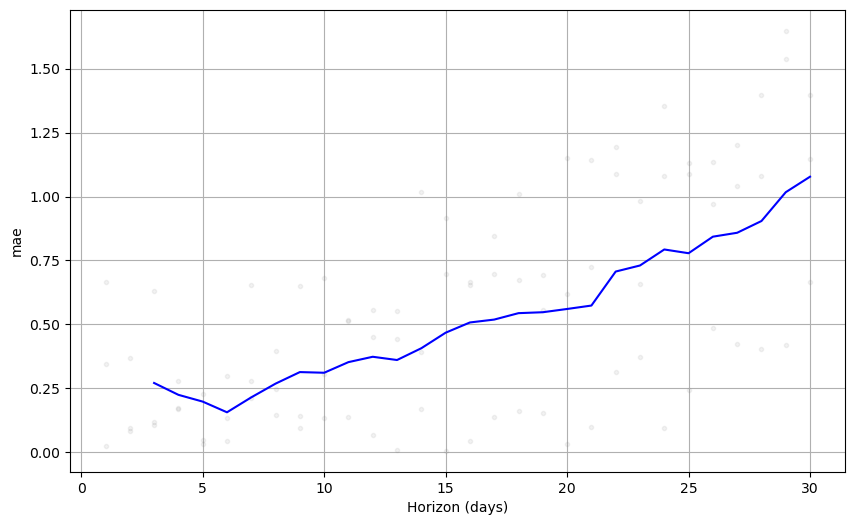

In [179]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [180]:
# Find the best parameters
tuning_results = pd.DataFrame(to_tune)
tuning_results["mae"] = ne_maes

In [181]:
tuning_results = tuning_results.sort_values(by = "mae")
tuning_results.reset_index(inplace = True, drop = True)

In [182]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,mae
0,0.500,0.01,10.00,0.208561
1,0.500,0.01,1.00,0.210607
2,0.500,1.00,1.00,0.210724
3,0.500,0.01,0.10,0.210988
4,0.500,0.10,10.00,0.211500
5,0.500,10.00,0.10,0.212416
6,0.500,1.00,0.10,0.212539
7,0.500,10.00,10.00,0.214409
8,0.500,0.10,0.10,0.214699
9,0.500,10.00,1.00,0.216336


In [184]:
# Find the best hyperparameter
best_params = to_tune[np.argmin(ne_maes)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0}


## NE Region Model

In [185]:
ne_tuned_prophet = Prophet(**best_params)
ne_tuned_prophet.add_country_holidays(country_name='US')
ne_tuned_prophet.add_regressor("cat__social_distancing_travel_distance_grade_F")
ne_tuned_prophet.add_regressor("num__daily_state_test")

In [186]:
ne_tuned_prophet.fit(ne_train) 

20:16:32 - cmdstanpy - INFO - Chain [1] start processing
20:16:32 - cmdstanpy - INFO - Chain [1] done processing


In [187]:
ne_tuned_future = ne_tuned_prophet.make_future_dataframe(periods=ne_train.shape[0])
ne_tuned_future = pd.merge(ne_tuned_future, ne_train.loc[:, ne_cols], left_index = True, right_index = True)
ne_tuned_forecast = ne_tuned_prophet.predict(ne_tuned_future)

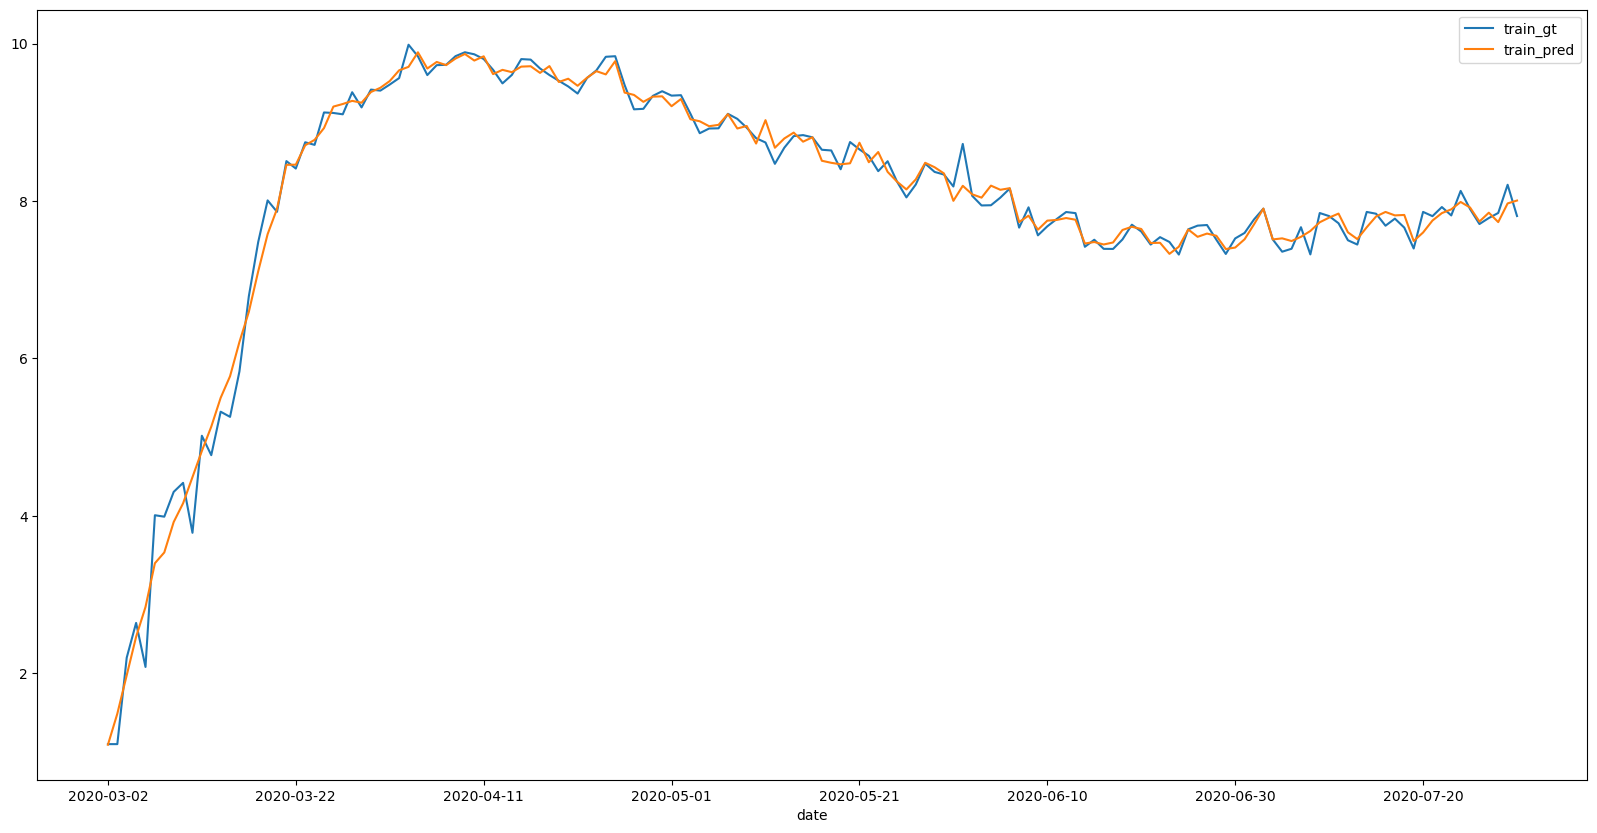

In [188]:
# Visualizing train data fitted values
ne_train_pred = ne_tuned_forecast["yhat"]
ne_train_pred.index = ne_train_plot.index
pd.concat([ne_train_plot, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [189]:
ne_tuned_future = ne_tuned_prophet.make_future_dataframe(periods=ne_test.shape[0])
ne_tuned_future = pd.merge(ne_tuned_future, ne_test.loc[:, ne_cols], left_index = True, right_index = True)
ne_tuned_forecast = ne_tuned_prophet.predict(ne_tuned_future)

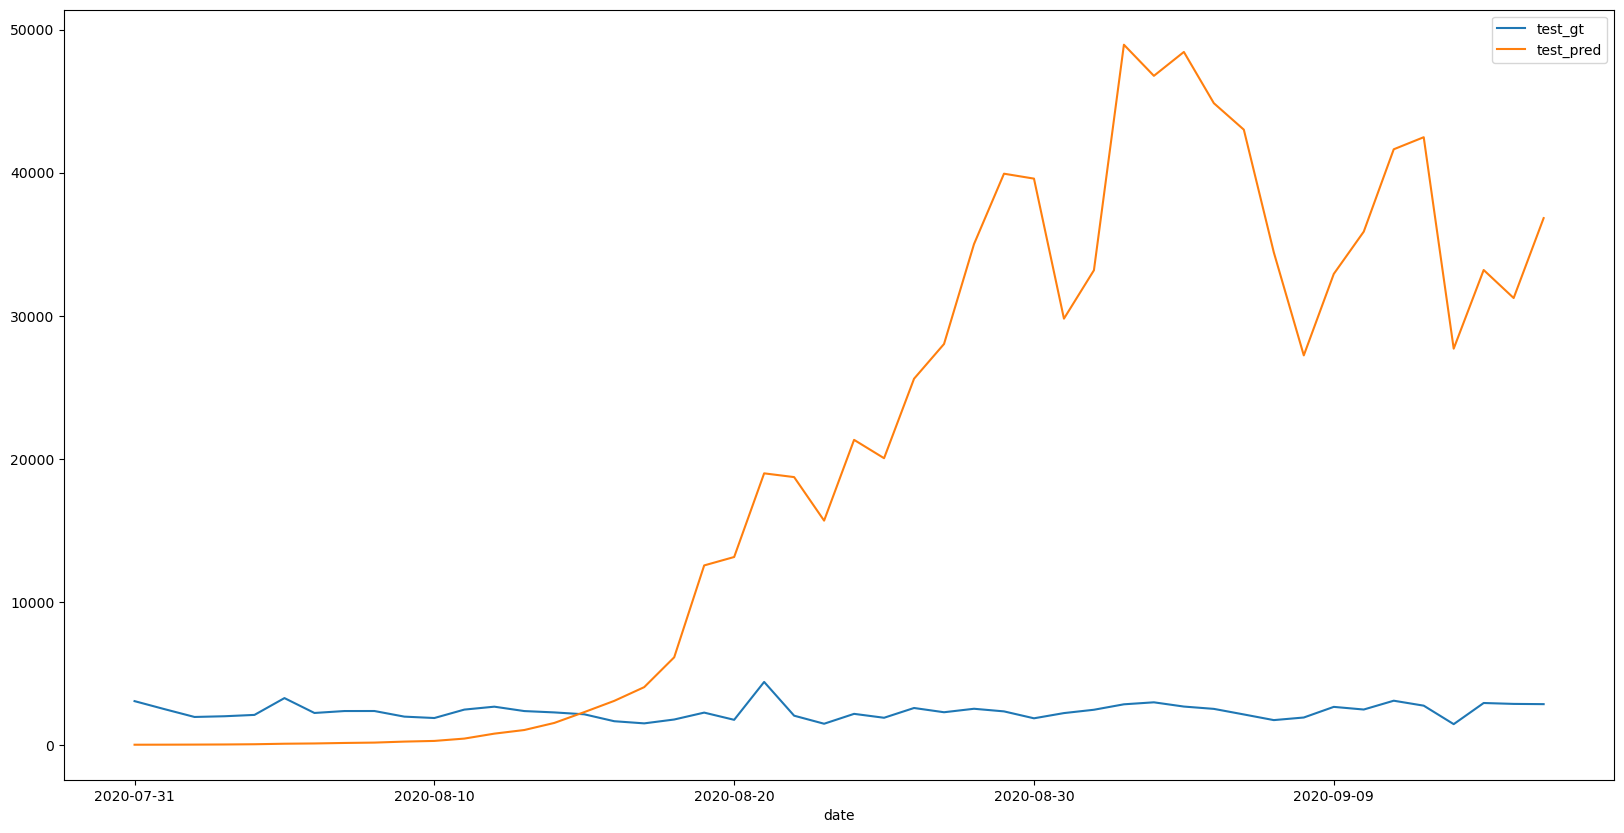

In [190]:
# Visualizing test data fitted values
ne_test_pred = ne_tuned_forecast["yhat"]
ne_test_pred = np.exp(ne_test_pred)
ne_test_pred.index = ne_test_plot.index
pd.concat([ne_test_plot, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [191]:
# MAE on test data
mean_absolute_error(ne_test_plot, ne_test_pred)

18669.71563990923

## S Region

In [161]:
s_maes = []

In [162]:
# Use cross validation to evaluate all parameters
for params in to_tune:
    s_tuned_prophet = Prophet(**params)
    s_tuned_prophet.add_country_holidays(country_name='US')
    s_tuned_prophet.add_regressor("num__daily_state_test")
    s_tuned_prophet.fit(s_train) 
    
    df_cv = cross_validation(s_tuned_prophet, initial='90 days', 
                             period='15 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    s_maes.append(df_p["mae"].values[0])

19:59:26 - cmdstanpy - INFO - Chain [1] start processing
19:59:26 - cmdstanpy - INFO - Chain [1] done processing
19:59:27 - cmdstanpy - INFO - Chain [1] start processing
19:59:27 - cmdstanpy - INFO - Chain [1] start processing
19:59:27 - cmdstanpy - INFO - Chain [1] start processing
19:59:27 - cmdstanpy - INFO - Chain [1] done processing
19:59:27 - cmdstanpy - INFO - Chain [1] done processing
19:59:27 - cmdstanpy - INFO - Chain [1] done processing
19:59:27 - cmdstanpy - INFO - Chain [1] start processing
19:59:27 - cmdstanpy - INFO - Chain [1] done processing
19:59:28 - cmdstanpy - INFO - Chain [1] start processing
19:59:28 - cmdstanpy - INFO - Chain [1] start processing
19:59:28 - cmdstanpy - INFO - Chain [1] done processing
19:59:28 - cmdstanpy - INFO - Chain [1] start processing
19:59:28 - cmdstanpy - INFO - Chain [1] done processing
19:59:28 - cmdstanpy - INFO - Chain [1] done processing
19:59:28 - cmdstanpy - INFO - Chain [1] start processing
19:59:28 - cmdstanpy - INFO - Chain [1]

19:59:41 - cmdstanpy - INFO - Chain [1] done processing
19:59:41 - cmdstanpy - INFO - Chain [1] start processing
19:59:41 - cmdstanpy - INFO - Chain [1] done processing
19:59:41 - cmdstanpy - INFO - Chain [1] start processing
19:59:41 - cmdstanpy - INFO - Chain [1] start processing
19:59:41 - cmdstanpy - INFO - Chain [1] start processing
19:59:41 - cmdstanpy - INFO - Chain [1] done processing
19:59:41 - cmdstanpy - INFO - Chain [1] done processing
19:59:42 - cmdstanpy - INFO - Chain [1] done processing
19:59:42 - cmdstanpy - INFO - Chain [1] start processing
19:59:42 - cmdstanpy - INFO - Chain [1] done processing
19:59:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:59:42 - cmdstanpy - INFO - Chain [1] start processing
19:59:42 - cmdstanpy - INFO - Chain [1] done processing
19:59:42 - cmdstanpy - INFO - Chain [1] start processing
19:59:42 - cmdstanpy - INFO - Chain [1] start process

19:59:54 - cmdstanpy - INFO - Chain [1] done processing
19:59:54 - cmdstanpy - INFO - Chain [1] start processing
19:59:54 - cmdstanpy - INFO - Chain [1] start processing
19:59:54 - cmdstanpy - INFO - Chain [1] start processing
19:59:54 - cmdstanpy - INFO - Chain [1] done processing
19:59:54 - cmdstanpy - INFO - Chain [1] done processing
19:59:55 - cmdstanpy - INFO - Chain [1] done processing
19:59:55 - cmdstanpy - INFO - Chain [1] start processing
19:59:55 - cmdstanpy - INFO - Chain [1] done processing
19:59:56 - cmdstanpy - INFO - Chain [1] start processing
19:59:56 - cmdstanpy - INFO - Chain [1] start processing
19:59:56 - cmdstanpy - INFO - Chain [1] start processing
19:59:56 - cmdstanpy - INFO - Chain [1] done processing
19:59:56 - cmdstanpy - INFO - Chain [1] done processing
19:59:56 - cmdstanpy - INFO - Chain [1] done processing
19:59:56 - cmdstanpy - INFO - Chain [1] start processing
19:59:56 - cmdstanpy - INFO - Chain [1] done processing
19:59:56 - cmdstanpy - INFO - Chain [1] 

20:00:08 - cmdstanpy - INFO - Chain [1] done processing
20:00:08 - cmdstanpy - INFO - Chain [1] start processing
20:00:08 - cmdstanpy - INFO - Chain [1] done processing
20:00:09 - cmdstanpy - INFO - Chain [1] start processing
20:00:09 - cmdstanpy - INFO - Chain [1] start processing
20:00:09 - cmdstanpy - INFO - Chain [1] start processing
20:00:09 - cmdstanpy - INFO - Chain [1] done processing
20:00:09 - cmdstanpy - INFO - Chain [1] done processing
20:00:09 - cmdstanpy - INFO - Chain [1] done processing
20:00:09 - cmdstanpy - INFO - Chain [1] start processing
20:00:10 - cmdstanpy - INFO - Chain [1] done processing
20:00:10 - cmdstanpy - INFO - Chain [1] start processing
20:00:10 - cmdstanpy - INFO - Chain [1] start processing
20:00:10 - cmdstanpy - INFO - Chain [1] done processing
20:00:10 - cmdstanpy - INFO - Chain [1] start processing
20:00:10 - cmdstanpy - INFO - Chain [1] done processing
20:00:10 - cmdstanpy - INFO - Chain [1] done processing
20:00:10 - cmdstanpy - INFO - Chain [1] 

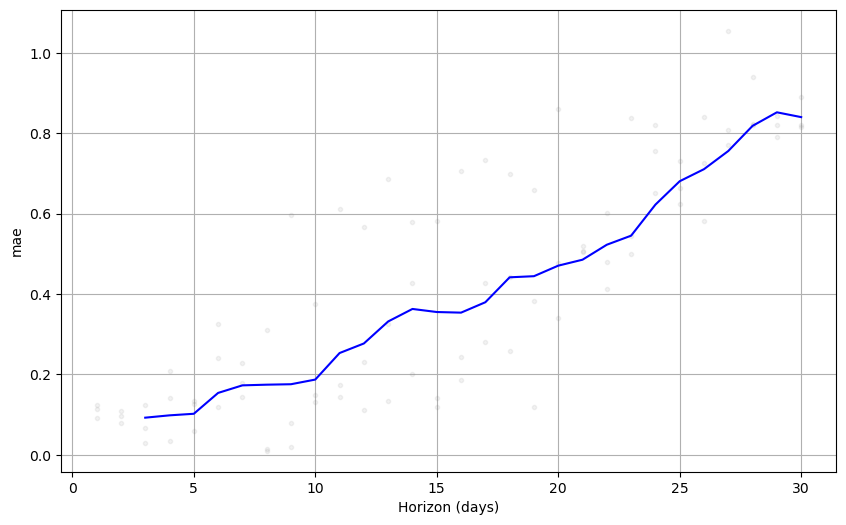

In [163]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [164]:
# Find the best parameters
tuning_results = pd.DataFrame(to_tune)
tuning_results["mae"] = s_maes

In [165]:
tuning_results = tuning_results.sort_values(by = "mae")
tuning_results.reset_index(inplace = True, drop = True)

In [166]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range,mae
0,0.500,0.01,0.01,additive,0.90,0.045154
1,0.500,0.01,10.00,multiplicative,0.85,0.048385
2,0.500,10.00,1.00,additive,0.95,0.050069
3,0.500,10.00,0.10,additive,0.90,0.050884
4,0.500,0.01,10.00,additive,0.85,0.053450
5,0.500,10.00,10.00,additive,0.85,0.056147
6,0.500,0.10,1.00,additive,0.85,0.056409
7,0.500,1.00,0.10,additive,0.85,0.056713
8,0.500,10.00,0.01,multiplicative,0.80,0.063815
9,0.500,1.00,10.00,multiplicative,0.80,0.064230


In [167]:
# Find the best hyperparameter
best_params = to_tune[np.argmin(s_maes)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


## S Region Model

In [168]:
s_tuned_prophet = Prophet(**best_params)
s_tuned_prophet.add_country_holidays(country_name='US')
s_tuned_prophet.add_regressor("num__daily_state_test")

In [169]:
s_tuned_prophet.fit(s_train) 

20:00:15 - cmdstanpy - INFO - Chain [1] start processing
20:00:15 - cmdstanpy - INFO - Chain [1] done processing


In [170]:
s_tuned_future = s_tuned_prophet.make_future_dataframe(periods=s_train.shape[0])
s_tuned_future = pd.merge(s_tuned_future, s_train.loc[:, s_cols], left_index = True, right_index = True)
s_tuned_forecast = s_tuned_prophet.predict(s_tuned_future)

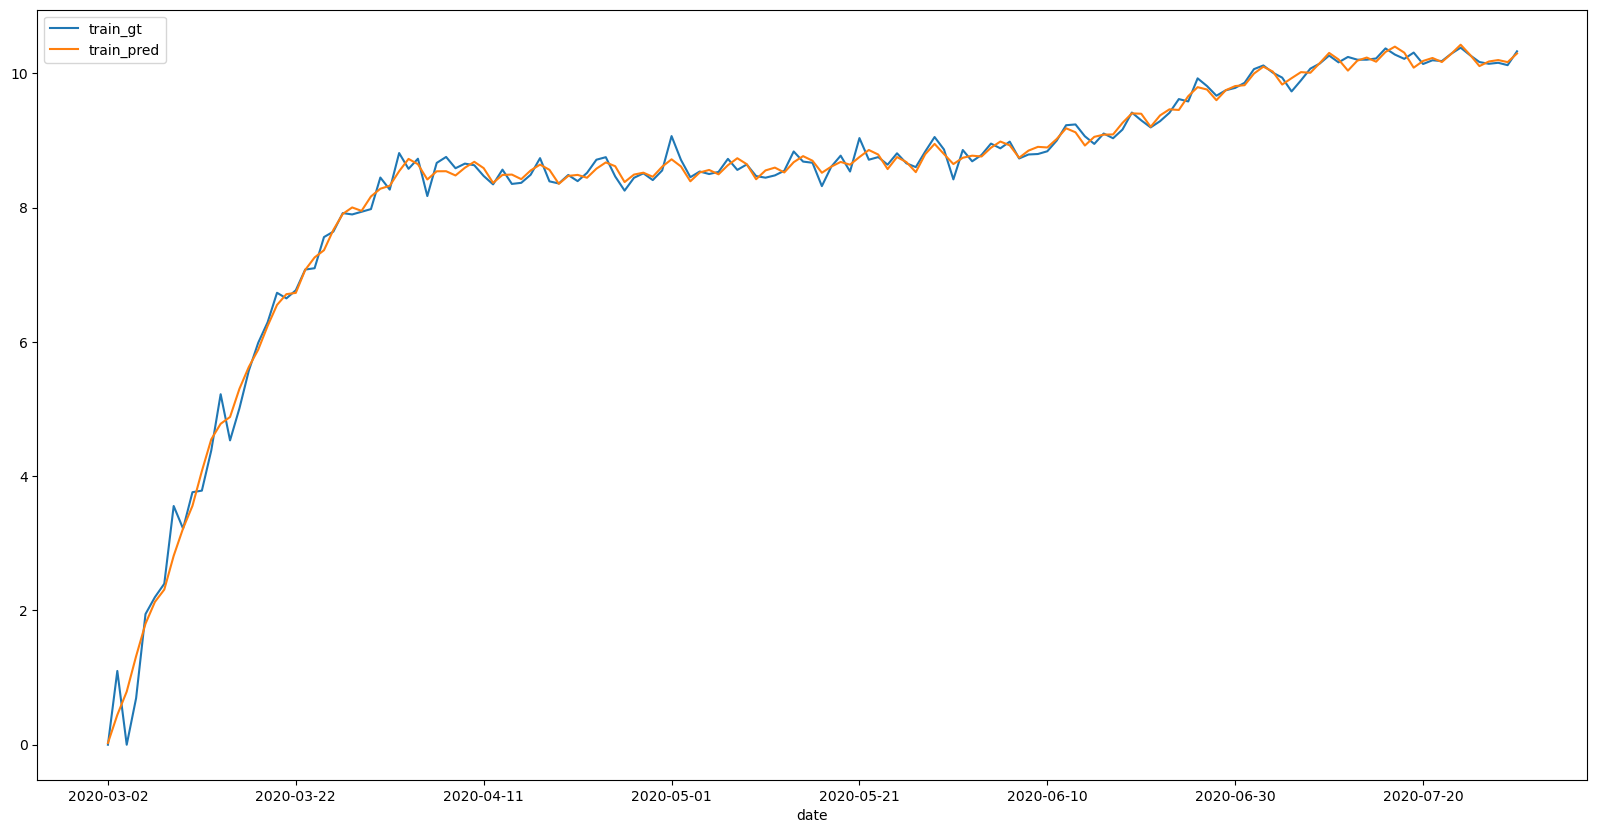

In [171]:
# Visualizing train data fitted values
s_train_pred = s_tuned_forecast["yhat"]
s_train_pred.index = s_train_plot.index
pd.concat([s_train_plot, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [172]:
s_tuned_future = s_tuned_prophet.make_future_dataframe(periods=s_test.shape[0])
s_tuned_future = pd.merge(s_tuned_future, s_test.loc[:, s_cols], left_index = True, right_index = True)
s_tuned_forecast = s_tuned_prophet.predict(s_tuned_future)

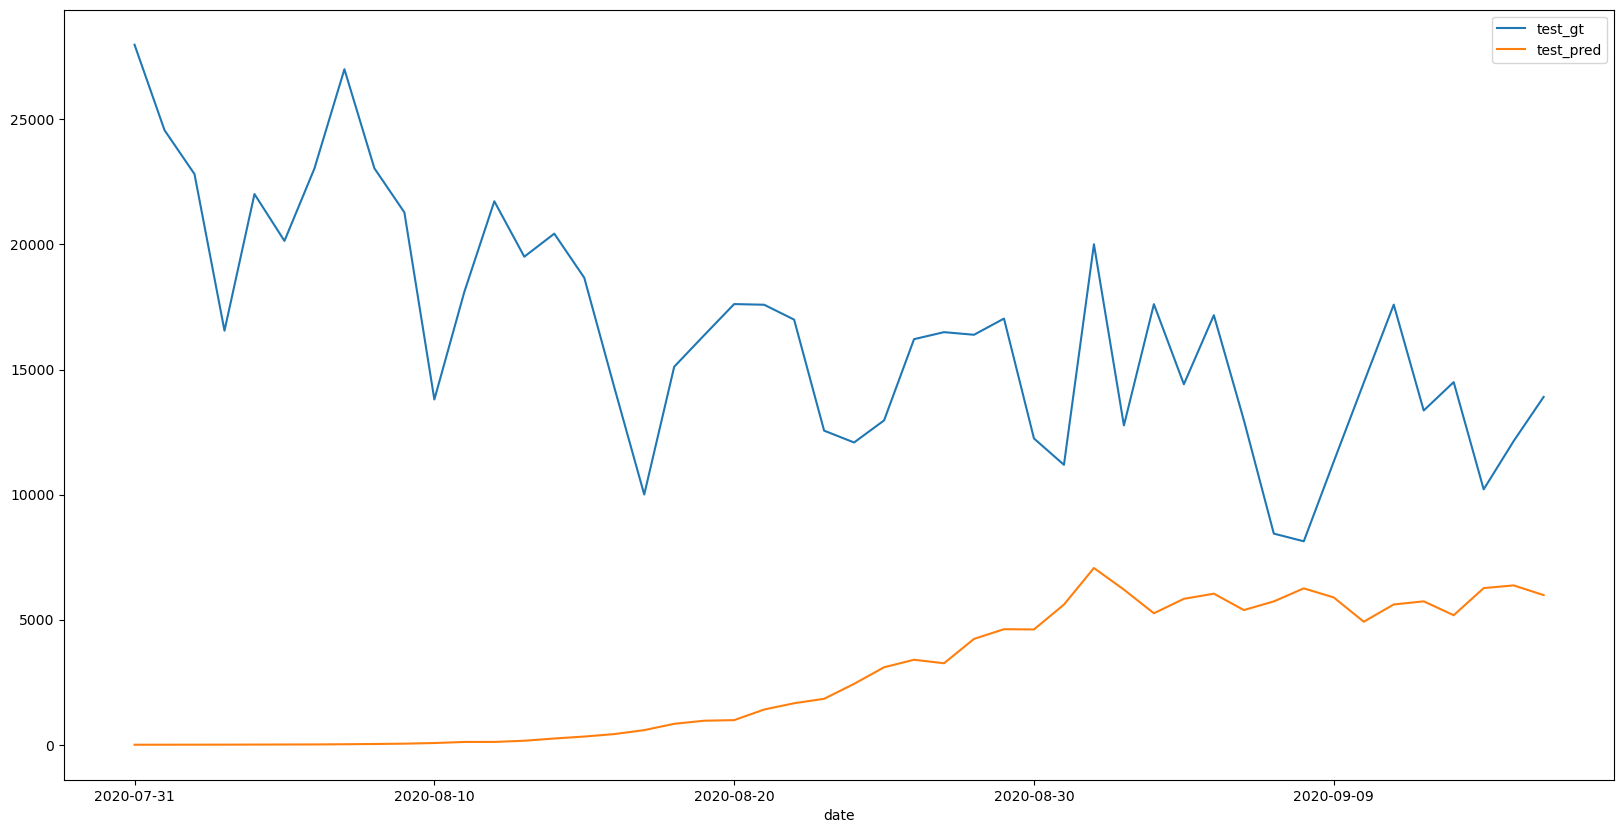

In [173]:
# Visualizing test data fitted values
s_test_pred = s_tuned_forecast["yhat"]
s_test_pred = np.exp(s_test_pred)
s_test_pred.index = s_test_plot.index
pd.concat([s_test_plot, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [174]:
# MAE on test data
mean_absolute_error(s_test_plot, s_test_pred)

13751.538023514933